<a href="https://colab.research.google.com/github/CocoTheAussieCat/dl_at3/blob/donald1/Group_model_DataGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### RUN THIS CELL ###
# Use more recent version of tensorflow
%tensorflow_version 2.x

# Mount Google Drive -- RUN
All data is located in `Experimentation` folder of Google Drive. 

In [1]:
### RUN THIS CELL ###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
### RUN THIS CELL ###
# Direct the workbook into the project folder
%cd drive/Shared\ drives/DL_AT3/ImageCaptioning

/content/drive/Shared drives/DL_AT3/ImageCaptioning


In [0]:
### RUN THIS CELL ###
import os 
dataset_dir = os.getcwd() 

In [5]:
### RUN THIS CELL ###
# Check the directory
dataset_dir

'/content/drive/Shared drives/DL_AT3/ImageCaptioning'

In [6]:
### RUN THIS CELL ###
# Check working director set correctly
!pwd

/content/drive/Shared drives/DL_AT3/ImageCaptioning


In [0]:
### RUN THIS CELL ###
# Check the files inside the directory
!ls

captions.txt		    Flickr8k_text.zip
checkpoints		    Flickr8k.token.txt
CrowdFlowerAnnotations.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    glove.6B.200d.txt
Flicker8k_Dataset	    Group_model.ipynb
Flickr8k_Dataset.zip	    __MACOSX
Flickr_8k.devImages.txt     readme.txt
Flickr8k.lemma.token.txt    train_features_inception.pkl
Flickr_8k.testImages.txt    val_features_inception.pkl


## Unzip files from Google Drive
Only required once, if files are already lists in the directory unzipping is not required again.

In [0]:
#Unzip the Image Dataset
#!unzip Flickr8k_Dataset.zip

In [0]:
#Unzip the Text Dataset
#!unzip Flickr8k_text.zip

## Set paths for files

In [0]:
### RUN THIS CELL ###
# Set the dataset directory and relative directories
image_dir = dataset_dir + '/Flicker8k_Dataset'
caption_dir = dataset_dir + '/Flickr8k.token.txt'
train_dir = dataset_dir + '/Flickr_8k.trainImages.txt'
test_dir = dataset_dir + '/Flickr_8k.testImages.txt'
val_dir = dataset_dir +'/Flickr_8k.devImages.txt'


# Setup -- RUN

Import libraries, set working directory and relative paths

In [0]:
### RUN THIS CELL ###
import pandas as pd
import numpy as np
from numpy import argmax
import array as arr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from pickle import dump, load
import string
import os
from time import time
import time
import random

from PIL import Image
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding, Dropout, Add, TimeDistributed, RepeatVector, Activation, Reshape, concatenate,BatchNormalization

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
	
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

## Set seeds
For reproducible results

In [0]:
### RUN THIS CELL ###
# Set seeds for numpy and tensorflow
tf.random.set_seed(12)
np.random.seed(12)

## Train and validation file names
Create lists of train and validation file names.

In [0]:
### RUN THIS CELL ###
# Gets all files in directory and extracts filename without extension
# Returns a list
def img_id(filename):
    with open(filename) as file:
        data = file.readlines()
        img_name = []
        for img_id in data:
            img_name.append(img_id.split('.')[0])
    return img_name    

In [11]:
### RUN THIS CELL ###
train_img_name = img_id(train_dir) 
val_img_name = img_id(val_dir) 

# Print 5 sample image names
print(*train_img_name[:5],sep='\n') 

# Check length of train and validation datasets
print('\nNumber of images in train data:',len(train_img_name)) 
print('\nNumber of images in val data:',len(val_img_name))

2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87

Number of images in train data: 6000

Number of images in val data: 1000


# Caption pre-processing -- DO NOT RUN
Source: <https://github.com/akki3d76/Image-Captioning-Using-Keras/blob/master/Captionate.ipynb>

Each image has 5 captions (#0 to #4). The 5 captions are turned into a list with the associated image id. Captions are then cleaned to remove punctuation. 

This is saved as `caption.txt` so this code DOES NOT need to be run again.

## Load captions from .txt file

In [0]:
### DO NOT RUN THIS CELL ###
# def load_doc(filename):
#     with open(filename) as file:
#         text = file.readlines()
#         return text

In [0]:
### DO NOT RUN THIS CELL ###
# text = load_doc(caption_dir)
# for line in text[:10]:
#     print(line,end='')

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


## Map images file names to captions
Create a dictionary of captions with corresponding image file name (with .jpg extension removed)

In [0]:
### DO NOT RUN THIS CELL ###
# def image_to_captions(text):
#     hash_map = {}
#     for line in text:
#         token = line.split()
#         image_id = token[0].split('.')[0] # separating with '.' to extract image id (removing .jpg)
#         image_caption = ' '.join(token[1: ])
        
#         if(image_id not in hash_map):
#             hash_map[image_id] = [image_caption]
#         else:
#             hash_map[image_id].append(image_caption)
        
#     return hash_map

In [0]:
### DO NOT RUN THIS CELL ###
# map_img_to_captions = image_to_captions(text)

# # print five captions for sample image
# print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


## Clean captions


In [0]:
### DO NOT RUN THIS CELL ###
# For each image, clean captions and put all five captions into single list

# def preprocess(map_img_to_captions):
#     preprocessed_captions = []
#     for key in map_img_to_captions.keys():
#         for idx in range(len(map_img_to_captions[key])):
#             tokens = map_img_to_captions[key][idx].split()
#             tokens = [token.lower() for token in tokens if len(token)>1 if token.isalpha()]
#             map_img_to_captions[key][idx] = ' '.join(tokens)
            
#     return map_img_to_captions

In [0]:
### DO NOT RUN THIS CELL ###
# preprocessed_map = preprocess(map_img_to_captions)

# # print list of captions for sample image
# preprocessed_map['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Create vocabulary from captions
Build a set with unique words from all the captions. Check by printing out the size of the vocab.

In [0]:
### DO NOT RUN THIS CELL ###
# Make a set of unique words in all the captions
# def create_vocabulary(preprocessed_map):
#     vocabulary = set()
#     for img_captions in preprocessed_map.values(): # list of 5 captions for each image
#         for caption in img_captions:
#             for token in caption.split():
#                 vocabulary.add(token)    
#     return vocabulary

In [0]:
### DO NOT RUN THIS CELL ###
# vocabulary = create_vocabulary(preprocessed_map)

# # Check vocab size
# print('Vocabulary size',len(vocabulary))

Vocabulary size 8357


## Save captions.txt
Save image id and clean captions as `captions.txt` in working directory.



In [0]:
### DO NOT RUN THIS CELL ###
# Create list of image ids and preprocessed captions, which is written to txt file
# def save_captions(preprocessed_map,filename):
#     data = []
#     for image_id,image_captions in preprocessed_map.items():
#         for caption in image_captions:
#             data.append(image_id + ' ' + caption + '\n')
            
#     with open(filename,'w') as file:
#         for line in data:
#             file.write(line)

In [0]:
### DO NOT RUN THIS CELL ###
# save_captions(preprocessed_map,'captions.txt') # will save to working directory

# Image pre-processing -- DO NOT RUN
Images are pre-processed so they can be run through Inceptions-V3 to extract features. 

Feature vector for train images saved as `features_train_inception.pkl` and for validation images saved as `features_val_inception.pkl`.


## Pre-process images
Pre-process so images are in correct format to be fed into Inception-V3 model for feature extraction.

Extract feature vectors are saved as `features_train_inception.pkl` and `features_val_inception.pkl` so this code DOES NOT need to be run again.

### Create lists of train and validation image file names, including .jpg extension

In [0]:
### DO NOT RUN THIS CELL ###

# def images_name(path):
#     img_name = set([path+image for image in os.listdir(path)])
#     return img_name

In [0]:
### DO NOT RUN THIS CELL ###

# all_images_filnames = images_name(image_dir)
# train_img_filenames = [image_dir + '/' + img + '.jpg' for img in train_img_name]
# val_img_filenames = [image_dir + '/' + img + '.jpg' for img in val_img_name]

### Pre-process images as required for Inception-V3

In [0]:
### DO NOT RUN THIS CELL ###
# Loads image, adds 4th dimension for colour channel, pre-process for Inception-V3
# Returns array with dims (1, 299, 299, 3)

# def preprocess_image(img_path):
#     img = image.load_img(img_path,target_size=(299,299)) 
#     img = image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
#     img = np.expand_dims(img, axis=0) # Add one more dimension: (1, 299, 299, 3)
#     img = preprocess_input(img) # Pre-process image as per Inception-V3 model
#     return img  # shape: (1, 299, 299, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


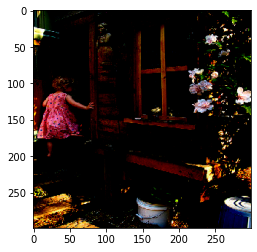

In [0]:
### DO NOT RUN THIS CELL ###
# Check preprocess_image works by running one sample image through it

# sample_image = image_dir +'/1000268201_693b08cb0e.jpg'
# img = preprocess_image(sample_image)
# plt.imshow(img[0])

## Load Inception-V3 model
Load model and remove last layer so that features can be extracted from images.

In [0]:
### DO NOT RUN THIS CELL ###
# Load Inception-V3 model
# model = InceptionV3(weights='imagenet')

# # Create new model, by removing last layer (output layer) from Inception-V3
# model_new = Model(inputs=model.input, outputs=model.layers[-2].output) # outputs=(second last layer output)

96116736/96112376 [==============================] - 1s 0us/step


## Extract feature from images
Run images through Inception-V3 model to extract features as a vector. Each image will have dimensions of (2048, ), which is the required size for modelling

In [0]:
### DO NOT RUN THIS CELL ###
# Function to extract features from image into a vector of size (2048, )
# def extract_image_features(image):

#     # pre-process image so it can be run through Inception-V3
#     image = preprocess_image(image)
    
#     # Extract features from image by running it through Inception-V3
#     feature_vector = model_new.predict(image) 

#     # Reshape from (1, 2048) to (2048, )
#     feature_vector = feature_vector.reshape(feature_vector.shape[1], ) 

#     return feature_vector

In [0]:
### DO NOT RUN THIS CELL ###
# Extract features from train images
# start_train = time()
# train_features = {}
# for idx,img in enumerate(train_img_filenames):
#     if( (idx+1)%500 == 0):
#         print('Train images encoded ',idx+1)
#     train_features[img] = extract_image_features(img)
# print("Train image feature extraction took: {} seconds".format(time()-start_train))

Train images encoded  500
Train images encoded  1000
Train images encoded  1500
Train images encoded  2000
Train images encoded  2500
Train images encoded  3000
Train images encoded  3500
Train images encoded  4000
Train images encoded  4500
Train images encoded  5000
Train images encoded  5500
Train images encoded  6000
Train image feature extraction took: 3345.310848712921 seconds


In [0]:
### DO NOT RUN THIS CELL ###
# Save train feature as pickle file
# Will save to working directory
dump(train_features, open('train_features_inception.pkl', 'wb'))

In [0]:
### DO NOT RUN THIS CELL ###
# Extract features from validation images
# start_val = time()
# val_features = {}
# for idx,img in enumerate(val_img_filenames):
#     if( (idx+1)%500 == 0):
#         print('Validation images encoded ',idx+1)
#     val_features[img] = extract_image_features(img)
# print("Validation image feature extraction took: {} seconds".format(time()-start_val))

Validation images encoded  500
Validation images encoded  1000
Validation image feature extraction took: 568.206071138382 seconds


## Save extracted image feature to pickles


In [0]:
### DO NOT RUN THIS CELL ###
# Save validation feature as pickle file
# Will save to working directory
# dump(val_features, open('val_features_inception.pkl', 'wb'))

# Load image features and captions -- RUN
Load image features from pickle files and get associated captions from caption dictionary

In [0]:
### RUN THIS CELL ###
def load_doc(filename):
    with open(filename) as file:
        text = file.readlines()
        return text

In [0]:
### RUN THIS CELL ###
# Creates dictionary with image id as key, captions as value
# Adds 'startseq' and 'endseq' to caption
def load_captions(filename, filelist):
    doc = load_doc(filename) 
    captions = {}    
    
    for line in doc:
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]

        if(image_id in filelist):
            if(image_id not in captions):
                captions[image_id] = []
            
            modified_caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            captions[image_id].append(modified_caption)
    
    return captions

In [14]:
### RUN THIS CELL ###
# Create train captions dictionary
train_captions = load_captions('captions.txt', train_img_name)

# Print a sample caption as a check, should return 5 captions, each sandwiched between 'startseq' 'endseq'
print(*train_captions['1000268201_693b08cb0e'],sep='\n')

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [15]:
### RUN THIS CELL ###
# Create train captions dictionary
val_captions = load_captions('captions.txt', val_img_name)

# Print a sample caption as a check, should return 5 captions, each sandwiched between 'startseq' 'endseq'
print(*val_captions['2391812384_7429b5e567'],sep='\n')

startseq child dressed in purple clothing and hat runs in splashing water while man and small boy walk nearby endseq
startseq child wearing purple runs through splashing water while man in red looks on endseq
startseq family playing the spray of fountain endseq
startseq man and two toddlers get sprinkled as they pass an ornamental fountain endseq
startseq young girl wearing purple running through water endseq


In [16]:
### RUN THIS CELL ###
train_features = load(open('train_features_inception.pkl', "rb"))

# Create a list of all training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)

# Check by printing length of captions and first 10 captions   
assert len(all_train_captions) == 5 * len(train_img_name)
print(*all_train_captions[:10],sep='\n')


startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq black dog and spotted dog are fighting endseq
startseq black dog and dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


In [17]:
### RUN THIS CELL ###
val_features = load(open('val_features_inception.pkl', "rb"))

# Create a list of all training captions
all_val_captions = []
for captions in val_captions.values():
    for caption in captions:
        all_val_captions.append(caption)

# Check by printing length of captions and first 10 captions   
assert len(all_val_captions) == 5 * len(val_img_name)
print(*all_val_captions[:10],sep='\n')

startseq child and woman are at waters edge in big city endseq
startseq large lake with lone duck swimming in it with several people around the edge of it endseq
startseq little boy at lake watching duck endseq
startseq young boy waves his hand at the duck in the water surrounded by green park endseq
startseq two people are at the edge of lake facing the water and the city skyline endseq
startseq boy with stick kneeling in front of goalie net endseq
startseq child in red jacket playing street hockey guarding goal endseq
startseq young kid playing the goalie in hockey rink endseq
startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq
startseq hockey goalie boy in red jacket crouches by goal with stick endseq


#  Create vocab -- RUN
Select threshold for number of times a word must appear in training captions for word to be added to vocab.

Tokenize captions.


In [109]:
### RUN THIS CELL ###
# Set threshold for number of times word must appear in captions to be included in vocab
corpus_threshold = 10

# Create corpus by tokenizing all training captions
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)

# Create vocab by only including words from corpus that appears enough times in captions
vocab = []
for token,count in hash_map.items():
    if(count>=corpus_threshold):
        vocab.append(token)
        
print('Number of original tokens:',len(hash_map))
print('Number of tokens after threshold:',len(vocab))

Number of original tokens: 7265
Number of tokens after threshold: 1643


## Create word-to-index and index-to-word dictionaries

In [0]:
### RUN THIS CELL ###
word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

# Check lengths are identical
assert (len(index_to_word)) == (len(index_to_word))

## Find max length caption
Need to know max length caption to set padding size

In [0]:
### RUN THIS CELL ###
def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption:',max_len)
    return max_len

In [112]:
### RUN THIS CELL ###
max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption: 33


# DATA GENERATOR

In [0]:
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb

def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            temp = '/content/drive/Shared drives/DL_AT3/Experimentation/Flicker8k_Dataset/'
            photo = photos[temp + key +'.jpg']
            for desc in desc_list:
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n=0

## Load GloVe vectors
Source: <https://nlp.stanford.edu/projects/glove/>

Will match words that are similar, for example frog and toad.

glove.6B.200d.txt must be located in working directory. There is a copy in Experimentation folder in Google Drive


In [114]:
### RUN THIS CELL ###
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


In [0]:
### RUN THIS CELL ###
embedding_dim = 200

# Create 200-dim dense vector for each of the words in vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

# Check shape size        
assert embedding_matrix.shape == (vocab_size, embedding_dim)

In [25]:
embedding_matrix.shape

(1644, 200)

# Image caption model -- RUN
Based on merge-model described by Tanti et al. in *Where to put the Image in an Image Caption Generator*

source: <https://arxiv.org/abs/1703.09137>

## Define model

In [116]:
### RUN THIS CELL ###
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length_caption,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 33, 200)      328800      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

## Set final layers weights to equal embedding matrix


In [0]:
### RUN THIS CELL ###
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

## Compile model

In [0]:
### RUN THIS CELL ###
# Compile model using adam and categorical cross entropy loss
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate = learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#model.compile(loss='categorical_crossentropy', optimizer="adam")

# TRAIN MODEL WITH GENERATOR

## More complex train code. it changes the learning rate while traing 


In [0]:
from tqdm import tqdm

In [0]:
# number_pics_per_batch = 32
# steps = len(train_img_name)//number_pics_per_batch
#EPOCHS = 20

In [50]:
# WORING BUT NOT BEING SAVED IN GDRIVE AND COULDN'T GET THE EVALUATION TO WORK 

#dataset_dir
#check_path = 'checkpoints/donald/datagen' # CHANGE THIS
#!mkdir -p $check_path

#check_dir = check_path+'/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# model_path = os.path.join(dataset_dir,"data",f'caption-model.hdf5')  #save the model

# if not os.path.exists(model_path):  
#     for i in tqdm(range(EPOCHS*2)):   #EPOCHS*2
#         generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
#         model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        
#         model.optimizer.lr = 1e-4
#         number_pics_per_batch = 6
#         steps = len(train_captions)//number_pics_per_batch
        
#     for i in range(EPOCHS):
#         generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
#         model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
        
#         model.save_weights(model_path)
        
#         print(f"\Training took: {hms_string(time()-start)}")
        
# else:
#     model.load_weights(model_path)



  0%|          | 0/10 [00:00<?, ?it/s]

1000/1000 [==============================] - 92s 92ms/step - loss: 2.8162




 10%|█         | 1/10 [01:32<13:51, 92.35s/it]

1000/1000 [==============================] - 91s 91ms/step - loss: 2.8057




 20%|██        | 2/10 [03:03<12:14, 91.86s/it]

1000/1000 [==============================] - 90s 90ms/step - loss: 2.7921




 30%|███       | 3/10 [04:33<10:39, 91.39s/it]

1000/1000 [==============================] - 91s 91ms/step - loss: 2.7824




 40%|████      | 4/10 [06:04<09:07, 91.24s/it]

1000/1000 [==============================] - 89s 89ms/step - loss: 2.7710




 50%|█████     | 5/10 [07:33<07:33, 90.68s/it]

1000/1000 [==============================] - 88s 88ms/step - loss: 2.7619




 60%|██████    | 6/10 [09:02<06:00, 90.00s/it]

1000/1000 [==============================] - 89s 89ms/step - loss: 2.7524




 70%|███████   | 7/10 [10:30<04:28, 89.64s/it]

1000/1000 [==============================] - 88s 88ms/step - loss: 2.7404




 80%|████████  | 8/10 [11:58<02:58, 89.09s/it]

1000/1000 [==============================] - 86s 86ms/step - loss: 2.7296




 90%|█████████ | 9/10 [13:25<01:28, 88.28s/it]

1000/1000 [==============================] - 86s 86ms/step - loss: 2.7239




100%|██████████| 10/10 [14:51<00:00, 89.15s/it]

   1/1000 [..............................] - ETA: 0s - loss: 2.7643

1000/1000 [==============================] - 85s 85ms/step - loss: 2.7134


OSError: ignored

# Train and Test Data Generator 

In [0]:
# Set number of pictures per batch 
number_pics_per_batch = 32

In [0]:
train_generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)

In [0]:
val_generator = data_generator(val_captions, val_features, word_to_index, max_length_caption, number_pics_per_batch)

## Set callbacks
Make sure you set `check_path` correctly!


In [0]:
### RUN THIS CELL ###
# Set callbacks
#### MAKE A DIRECTORY TO SAVE CHECKPOINTS TO ##############################
# eg: check_path = 'checkpoints/rebecca/exp_2'
###########################################################################

check_path = 'checkpoints/donald/image_datagen4' # CHANGE THIS
!mkdir -p $check_path

check_dir = check_path+'/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# Monitor validation loss, saving only the best, stopping early if no improvement after 5 epochs, dropping learning rate if loss plateaux
checkpoint = ModelCheckpoint(check_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

## Train model

In [123]:
### RUN THIS CELL ###
# Fit model
tic = time.perf_counter()


history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_img_name) // number_pics_per_batch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_img_name) // number_pics_per_batch ,
    callbacks = [checkpoint, early_stopping, reduce_lr])


toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/30
187/187 [==============================] - ETA: 0s - loss: 4.8155
Epoch 00001: val_loss improved from inf to 4.07709, saving model to checkpoints/donald/image_datagen4/model-ep001-loss4.815-val_loss4.077.h5
187/187 [==============================] - 32s 173ms/step - loss: 4.8155 - val_loss: 4.0771 - lr: 0.0010
Epoch 2/30
187/187 [==============================] - ETA: 0s - loss: 3.8722
Epoch 00002: val_loss improved from 4.07709 to 3.66078, saving model to checkpoints/donald/image_datagen4/model-ep002-loss3.872-val_loss3.661.h5
187/187 [==============================] - 31s 167ms/step - loss: 3.8722 - val_loss: 3.6608 - lr: 0.0010
Epoch 3/30
187/187 [==============================] - ETA: 0s - loss: 3.5482
Epoch 00003: val_loss improved from 3.66078 to 3.48707, saving model to checkpoints/donald/image_datagen4/model-ep003-loss3.548-val_loss3.487.h5
187/187 [==============================] - 31s 166ms/step - loss: 3.5482 - val_loss: 3.4871 - lr: 0.0010
Epoch 4/30
187/187 [===

# Evaluate image caption model -- RUN
Plot loss curves.

Calculates BLEU scores.

## Loss curves


In [0]:
### RUN THIS CELL ###
def modelPlot(history_name, plt_title):
    """
    Generates plot (with title) for model training and validation accuracy and loss by epoch
    Inputs  - history_name = history object resulting from fitted model
            - plt_title = title for plot, as string
    Output  - plot
    """
    from matplotlib.pyplot import savefig
    accuracy_filename = check_path+'/acc.png'
    loss_filename = check_path+'/loss.png'
    # plt.plot(history_name.history['accuracy'], label='Training', color = 'blue')
    # plt.plot(history_name.history['val_accuracy'], label='Validation', color = 'orange')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.title(plt_title)
    # plt.legend()
    # plt.savefig(accuracy_filename)
    # plt.show()
    # plt.close()

    plt.plot(history_name.history['loss'], label='Training', color = 'blue')
    plt.plot(history_name.history['val_loss'], label='Validation', color = 'orange')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(plt_title)
    plt.legend()
    plt.savefig(loss_filename)
    plt.show()
    plt.close()

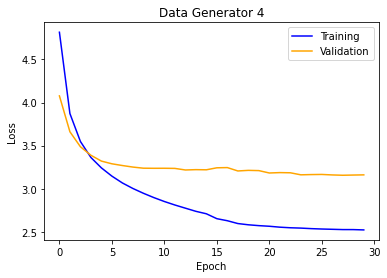

In [126]:
# Change title
title = 'Data Generator 4' # CHANGE THIS

# Plot will save to check_path as loss.png
modelPlot(history, title)

## BLEU scores


In [0]:
### RUN THIS CELL ###
# Find best model file name from model.fit output and insert below
best_model = 'checkpoints/donald/image_datagen4/model-ep028-loss2.526-val_loss3.156.h5' # CHANGE THIS

# Load best model
best_model = tf.keras.models.load_model(best_model)


In [0]:
### RUN THIS CELL ###
# Predict a caption for a word using model
def predict_caption(model, photo, wordtoix, ixtoword, max_length):
    photo = photo.reshape((1,2048))
    in_text = 'startseq'
    for i in range(max_length_caption):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
### RUN THIS CELL ###
# Evaluate model by predicting captions for images
# Compare predicted captions to truth captions
# Calculate BLEU-1 through BLEU-4 to determine model fit
def evaluate_model(model, captions, features, wordix, ixword, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in captions.items():
		# generate description
		temp = '/content/drive/Shared drives/DL_AT3/Experimentation/Flicker8k_Dataset/'
		photo = features[temp + key + '.jpg']
		yhat = predict_caption(best_model, photo, wordix, ixword, max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [130]:
### RUN THIS CELL ###
# Calculate BLEU scores on validation dataset for best model
tic = time.perf_counter()
evaluate_model(best_model, val_captions, val_features, word_to_index, index_to_word, max_length_caption)
toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model evaluated in: {run_time:0.2f} minutes')

BLEU-1: 0.465756
BLEU-2: 0.286315
BLEU-3: 0.203156
BLEU-4: 0.099267
Model evaluated in: 4.77 minutes
